In [49]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline
np.set_printoptions(precision=2)
import tensorflow as tf
tf.__version__

'2.12.1'

In [50]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

In [51]:
# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T

In [52]:
# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

In [53]:
print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


A generic layer class with forward and backward methods

In [54]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        pass
    
    def backward(self, output_gradient, learning_rate):
        pass


CCE loss and its gradient

In [55]:
def cce_gradient(Y, Yhat):
    return (-Y/Yhat)


Generic activation layer class

In [56]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient
    
    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return self.output

    def backward(self, output_gradient, learning_rate=None):
        return output_gradient * self.activation_gradient(self.input)


Specific activation layer classes

In [57]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))
        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)
        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)
        def tanh_gradient(z):
            return 1 - np.tanh(z) ** 2
        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return np.maximum(0, z)
        def relu_gradient(z):
            return 1. * (z > 0)
        super().__init__(relu, relu_gradient)


Softmax activation layer class

In [58]:
## Softmax activation layer class
class Softmax(Layer):
    def forward(self, input):
        self.output = tf.nn.softmax(input, axis=0).numpy()
    
    def backward(self, output_gradient):
        softmax_gradient = np.empty((self.output.shape[0], output_gradient.shape[1]), dtype=np.float64)
        for b in range(softmax_gradient.shape[1]):
            softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])) - np.atleast_2d(self.output[:, b]), np.atleast_2d(self.output[:, b]))
        # Return gradient w.r.t. input for backward propagation
        return softmax_gradient


Dense layer class

In [59]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
    
    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
    
    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the gradient w.r.t. weights
        weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        for b in range(output_gradient.shape[1]):
            weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        weights_gradient = (1/output_gradient.shape[1])*weights_gradient
        # Following is the efficient way of calculating the weightsgradient
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # Gradient w.r.t. the input
        input_gradient = np.dot(self.weights.T, output_gradient)
        # Update weights using gradient descent step
        self.weights = self.weights + learning_rate * (-weights_gradient)
        # Return gradient w.r.t. input for backward propagation
        return input_gradient


Function to generate sample indices for batch processing according to batch size

In [60]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
    # Reorder sample indices
    reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
    # Generate batch indices for batch processing
    batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
    return(batch_indices)

Train the 1-hidden layer neural network (128 nodes) using batch training with batch size = 100

In [80]:
## Train the 1-hidden layer neural network (128 nodes)
## using batch training with batch size = 100
learning_rate = 1e-3 # learning rate
batch_size = 100 # batch size
nepochs = 200 # number of epochs
loss_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store losses over each epoch
# Neural network architecture
dlayer1 = Dense(num_features, 128) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dlayer2 = Dense(128, num_labels) # define dense layer 2
softmax = Softmax() # define softmax activation layer
# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.
epoch = 0
while epoch < nepochs:
    batch_indices = generate_batch_indices(num_samples, batch_size)
    loss = 0
    for b in range(len(batch_indices)):
        dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
        alayer1.forward(dlayer1.output) # forward prop activation layer 1
        dlayer2.forward(alayer1.output) # forward prop dense layer 2
        softmax.forward(dlayer2.output) # Softmax activate
        loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss
        # Backward prop starts here
        grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
        grad = softmax.backward(grad)
        grad = dlayer2.backward(grad, learning_rate)
        grad = alayer1.backward(grad)
        grad = dlayer1.backward(grad, learning_rate)
    softmax.forward(softmax.output) # Softmax activate
    loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss
    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
    loss_epoch[epoch] = loss/len(batch_indices)
    print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
    epoch = epoch + 1
    if softmax.output is not None:
        grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output.T)
    else:
        grad = None
softmax.forward(?) # Softmax activate
loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss
# Backward prop starts here
grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
grad = softmax.backward(?)
grad = dlayer2.backward(? learning_rate)
grad = alayer1.backward(?)
grad = dlayer1.backward(?, learning_rate)
loss_epoch[epoch] = loss/len(batch_indices)
print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
epoch = epoch + 1
if softmax.output is not None:
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output.T)
else:
    grad = None


SyntaxError: invalid syntax (700805528.py, line 45)

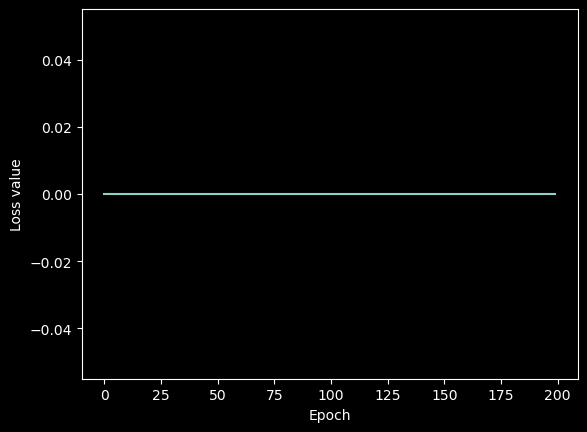

In [77]:
# Plot training loss as a function of epoch:
plt.plot(loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()